# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [375]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = sns.load_dataset('titanic')


In [376]:
# Data cleaning cont'd: 
# Dropping 'survived' because target variable
# Dropping 'alive' because same as target variable
# Dropping 'deck' because 77% of data missing
# Dropping 'embark_town' because same as 'embarked'
X = df.drop(columns = ['survived', 'alive', 'deck', 'embark_town'], axis=1) 
y = df['survived']

# Data cleaning cont'd: 
# replacing the 177 nans in age 

mean = X["age"].mean()
std = X["age"].std()
is_null = X["age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = X["age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
X["age"] = age_slice
X["age"] = X["age"].astype(int)
# X["age"].isnull().sum()

cat_var = ['sex', 'embarked', 'class', 'who', 'adult_male', 'alone'] #onehotencode
con_var = ['pclass', 'age', 'sibsp', 'parch', 'fare'] #going to square and cube
# can build a forloop 

ohe = pd.get_dummies(data=X, columns=cat_var, drop_first=True)


In [377]:
# Squaring continuous variables:
X_sq = X[con_var].apply(np.square)
X_sq.columns = df[con_var].columns+"_sq"
sq_df = pd.concat((X, X_sq), axis=1)

# Cubing continuous variables: 
X_cb = X[con_var] ** 3
X_cb.columns = df[con_var].columns+"_cb"
sq_df = pd.concat((X, X_sq), axis=1)

In [385]:
# Joining everything in one big happy blended dataframe family:
new_df = ohe.join(X_sq)
new_df = new_df.join(X_cb)


In [388]:
# Significant features kept from last time

# Linear model:
X = new_df[['pclass', 'class_Second', 'class_Third', 'adult_male_True', 'pclass_sq', 'sibsp_sq', 'pclass_cb', 'sibsp_cb']]
y = df['survived']

est = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est.summary() 

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 6
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     336.2
Date:                Sat, 06 Feb 2021   Prob (F-statistic):          2.69e-224
Time:                        20:29:40   Log-Likelihood:                -374.96
No. Observations:                 891   AIC:                             761.9
Df Residuals:                     885   BIC:                             790.7
Df Model:                           5                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5721      0.020     28.117      0.000       0.532       0.612
pclass              0.3733      0.009     39.349      0.000       0.355       0.392
class_Second       -0.3230      0.024    -13.491      0.000      -0.370      -0.276
class_Third         0.0621      0.006     10.769      0.000       0.051       0.073
adult_male_True    -0.5799      0.028    -20.470      0.000      -0.635      -0.524
pclass_sq           0.1001      0.008     11.855      0.000       0.084       0.117
sibsp_sq           -0.0508      0.008     -6.214      0.000      -0.067      -0.035
pclass_cb          -0.0736      0.003    -28.039      0.000      -0.079      -0.068
sibsp_cb            0.0057      0.001      5.188      0.000       0.004       0.008
==============================================================================
Omnibus:                       43.799   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.962
Skew:                           0.529   Prob(JB):                     1.42e-11
Kurtosis:                       3.478   Cond. No.                     1.35e+18
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 1.12e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [392]:
# With sklearn:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept = False)
mdl = model.fit(sm.add_constant(X), y)
mdl.coef_

array([[ 1.53637945,  0.95455258, -0.96985418,  0.19401366, -2.92800301,
         0.17892614, -0.04981667, -0.20824479, -0.02702344]])

In [395]:
# With statsmodel
import statsmodels.api as sm

# Doesn't like my pclass feature
logit = sm.Logit(y, sm.add_constant(X[['adult_male_True','class_Second', 'class_Third', 'sibsp_sq', 'sibsp_cb']])).fit(method='powell', maxiter=50000)
logit.summary()

Optimization terminated successfully.
         Current function value: 0.424798
         Iterations: 9
         Function evaluations: 687


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                  0.3621
Time:                        20:34:45   Log-Likelihood:                -378.49
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.194e-90
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.6742      0.252     10.597      0.000       2.180       3.169
adult_male_True    -3.1398      0.207    -15.180      0.000      -3.545      -2.734
class_Second       -1.0951      0.266     -4.121      0.000      -1.616      -0.574
class_Third        -2.0197      0.234     -8.632      0.000      -2.478      -1.561
sibsp_sq            0.0376      0.171      0.219      0.826      -0.298       0.373
sibsp_cb           -0.0524      0.047     -1.118      0.264      -0.144       0.039
===================================================================================
"""

In [396]:
from sklearn import metrics
from sklearn.metrics import classification_report


# y = df.survived
# X = df.drop(columns='survived')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
#convert results to binary predictions
f = lambda x: 1 if x > 0.5 else 0
vect_f = np.vectorize(f)
print(metrics.classification_report(y_test, vect_f(y_pred_lin)))

log_reg = LogisticRegression(max_iter=400).fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred_log))

# result are only slighly better

NameError: name 'LinearRegression' is not defined

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [416]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [420]:
# import numpy as np
# X_sq = X ** 2
# sq_df = np.concatenate((X, X_sq), axis=1)

# X_cb = X ** 3
# cb_df = np.concatenate((sq_df, X_cb), axis=1)
# cb_df.shape

## Accuracy is highest with no scaling and no polynomials 

In [417]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [413]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [414]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(scaled_X_train, y_train)

y_pred = log_model.predict(scaled_X_test)

In [415]:
accuracy_score(y_test, y_pred)

0.9146753246753246

In [418]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test) 

In [419]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_test, y_pred)

0.9190909090909091

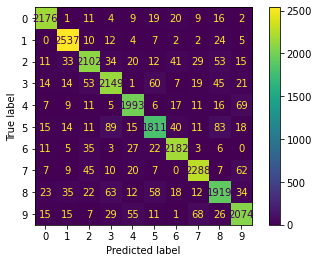

In [6]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log_model, X_test, y_test)

In [ ]:
# BELOW IS FOR SCALED

In [20]:
# pick one, and watch jose videos again to understand what to do
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
#for image processing, neural network (CNN)
# k-means = to find best number of clusters, use elbow method.  

In [21]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(scaled_X_train, y_train)

y_pred = log_model.predict(scaled_X_test) #will give predictions as 1s and 0s
# y_pred = log_model.predict_proba(scaled_X_test) #will give the predicted probabilities of belonging to 0 class and to 1 class . 

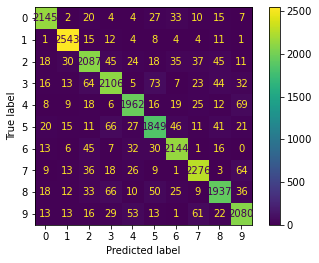

In [16]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log_model, scaled_X_test, y_test)

In [15]:
Xsca.shape #lmao dont know what this is 

(891, 10)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
y_pred  = log_model.predict(scaled_X_test)
accuracy_score(y_test, y_pred)

# Is this the 80% he is looking for??

0.9146753246753246

In [47]:
# confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(log_model, scaled_X_test, y_test), #normalize='all')

# len(y_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2267
           1       0.96      0.98      0.97      2603
           2       0.89      0.89      0.89      2350
           3       0.89      0.88      0.89      2383
           4       0.91      0.92      0.91      2144
           5       0.88      0.88      0.88      2107
           6       0.93      0.93      0.93      2294
           7       0.93      0.93      0.93      2455
           8       0.90      0.88      0.89      2196
           9       0.90      0.90      0.90      2301

    accuracy                           0.91     23100
   macro avg       0.91      0.91      0.91     23100
weighted avg       0.91      0.91      0.91     23100



In [48]:
# from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

# fig, ax = plt.subplots(figsize=(10,6), dpi=200)
# plot_roc_curve(log_model, scaled_X_test, y_test, ax=ax)

In [22]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

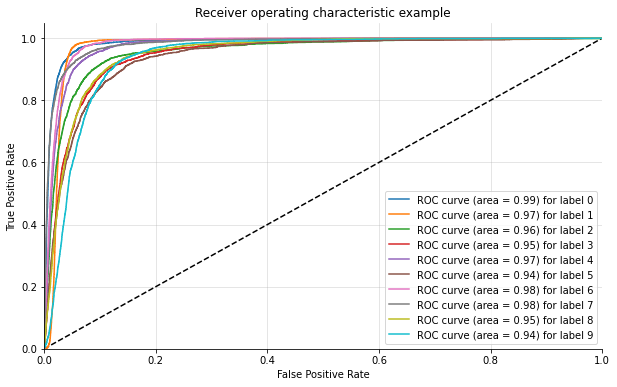

In [24]:
plot_multiclass_roc(log_model, scaled_X_test, y_test, n_classes=10, figsize=(10, 6))

In [ ]:
plot_precision_recall_curve(log_model, scaled_X_test, y_test)

In [46]:
# For raw probabilities for points, not just what the model chose (like it being 97% vs seeing a 1 returned)
log_model.predict_proba(scaled_X_test)[0] #vs
y_test[0] #how do they compare, did the probability match the actual value? 

In [49]:
# multinomial logistic regression?? Jose

from sklearn.model_selection import GridSearchCV
log_model = LogisticRegression(solver='saga', multi_class='ovr', max_iter=5000)

In [52]:
penalty = ['l1', 'l2', 'elasticnet']
l1_ratio = np.linspace(0,1,20)
C = np.logspace(0,10,20)

param_grid = {'penalty': penalty,
                'l1_ratio': l1_ratio,
                'C': C}


In [55]:
grid_model = GridSearchCV(log_model, param_grid=param_grid)

In [56]:
# grid_model.fit(scaled_X_train, y_train) #dont run, this is cray 

In [47]:
# should we be using LogisticRegressionCV? and what is that? #automatic hyperparameters testing 

(70000, 784)

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [ ]:
#1. poisson or binomial 
#2. logistic regression

In [ ]:
# QUESTION:
# HOW DO WE KNOW IF THEY FISHED VS IF THEY JUST DIDNT MANAGE TO CATCH ANY FISH???  they always went. 

In [ ]:
# targets: 
# -Fishing done Y or N (categorical, so logistic regression)
# -If Y, probability (between 0 or 1) that any fish at all were caught
# -If Y, how many fish caught

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
count,250.000000,250.000000,250.00000,250.000000,250.000000
mean,0.864000,0.588000,2.52800,0.684000,3.296000
std,0.343476,0.493182,1.11273,0.850315,11.635028
min,0.000000,0.000000,1.00000,0.000000,0.000000
25%,1.000000,0.000000,2.00000,0.000000,0.000000
50%,1.000000,1.000000,2.00000,0.000000,0.000000
75%,1.000000,1.000000,4.00000,1.000000,2.000000
max,1.000000,1.000000,4.00000,3.000000,149.000000


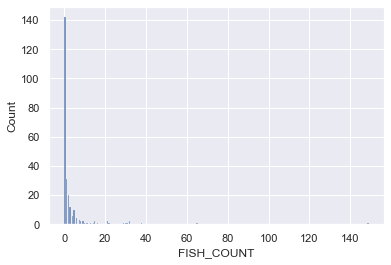

In [102]:
import pandas as pd
import seaborn as sns

dfish = pd.read_csv('data/fish.csv')
dfish.describe()

# categorical columns: LIVE_BAIT, CAMPER (already OHE)
# continuous columns: PERSONS, CHILDREN

# might be one fun outlier at 149 fish caught (FISH_COUNT)
sns.histplot(data=dfish, x='FISH_COUNT')

# dfish = dfish.drop(index = (dfish[dfish['FISH_COUNT'] > 40].index)) #can clip them instead and add column that says you clipped them #or log(1+y) or arcsinh
dfish.describe()

In [ ]:
#negative binomial, gamma regression (fits very exponentially distributions)
#log(1+y) or arcsinh(y) and then fit something more reasonable 

In [31]:
dfish.dtypes

LIVE_BAIT     int64
CAMPER        int64
PERSONS       int64
CHILDREN      int64
FISH_COUNT    int64
dtype: object

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
sns.set()

X = dfish.drop('FISH_COUNT', axis=1)
y = dfish.FISH_COUNT

est = sm.ZeroInflatedPoisson(y, sm.add_constant(X)).fit()
est.summary()

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Sat, 06 Feb 2021   Pseudo R-squ.:                  0.3471
Time:                         13:50:42   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

In [ ]:
#infl constant: not sign means that the likelihood that its zero inflated isnt very high. 

In [ ]:
# Two Stage Modelling 

In [104]:
# Stage 1
est1 = sm.Logit((y > 0).astype(int), sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


Optimization terminated successfully.
         Current function value: 3.145454
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      244
Method:                           MLE   Df Model:                            5
Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                  0.5228
Time:                        13:50:56   Log-Likelihood:                -786.36
converged:                       True   LL-Null:                       -1647.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1977      0.266    -12.018      0.000      -3.719      -2.676
LIVE_BAIT      1.9649      0.250      7.858      0.000       1.475       2.455
CAMPER         1.0589      0.119      8.895      0.000       0.826       1.292
PERSONS        1.4232      0.112     12.689      0.000       1.203       1.643
CHILDREN      -2.4239      0.231    -10.512      0.000      -2.876      -1.972
stage1        -2.1432      0.642     -3.339      0.001      -3.401      -0.885
==============================================================================
"""

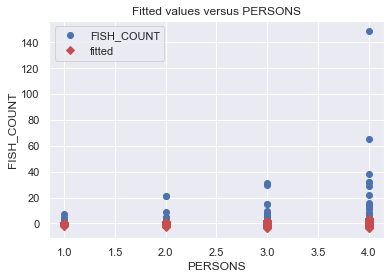

In [105]:
# Stage 1
# est1 = sm.Logit((y > 0).astype(int), sm.add_constant(X)).fit()
# Prep Stage 2
X = pd.DataFrame(sm.add_constant(X))
X['stage1'] = est1.predict(X)
# X.columns = ['const', 'x', 'stage1']
# Stage 2
est2 = sm.Poisson(y, X).fit()
sm.graphics.plot_fit(est2, 3, vlines=False)
est2.summary()

In [ ]:
#Stevens

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             FISH_COUNT   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sat, 06 Feb 2021   Prob (F-statistic):           2.90e-11
Time:                        12:51:35   Log-Likelihood:                -938.12
No. Observations:                 250   AIC:                             1888.
Df Residuals:                     244   BIC:                             1909.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4807      2.556     -4.100      0.000     -15.516      -5.445
LIVE_BAIT      6.3331      2.468      2.566      0.011       1.471      11.195
CAMPER         6.9381      2.233      3.108      0.002       2.541      11.336
PERSONS        9.5638      2.288      4.180      0.000       5.058      14.070
CHILDREN     -14.1342      3.950     -3.578      0.000     -21.915      -6.353
stage1       -23.8062     10.774     -2.210      0.028     -45.028      -2.584
==============================================================================
Omnibus:                      420.458   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114163.931
Skew:                           8.715   Prob(JB):                         0.00
Kurtosis:                     106.228   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

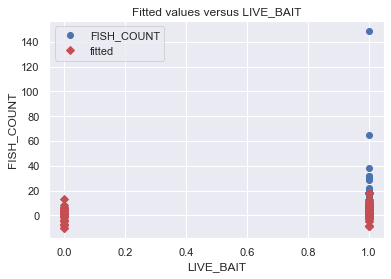

In [43]:
import pandas as pd
import seaborn as sns

fish = pd.read_csv('data/fish.csv')
fish.describe()



#Two-Stage Modelling:
X = sm.add_constant(fish.drop('FISH_COUNT',axis=1))
y = fish.FISH_COUNT
#Stage 1:
est1 = sm.Logit((y>0),X).fit()
#est1.summary()
# Prep Stage 2:
X = pd.DataFrame(sm.add_constant(X))
X['stage1'] = est1.predict(X)
#Stage 2:
est2 = sm.OLS(y,X).fit()
sm.graphics.plot_fit(est2,1,vlines=False)
est2.summary()

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [ ]:
# 5.1 Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

# Need 'how long theyve been a customer'
# Need 'Streaming TV y or no'

In [367]:
import numpy as np
import scipy.stats as st
import statsmodels.datasets
import matplotlib.pyplot as plt

telco = pd.read_csv('data/telco_churn.csv')

In [368]:
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [371]:
# telco.dtypes

In [369]:
# A few rows with NaN TotalCharges. Changed to the MonthlyCharge, as they had just begun their service
telco.TotalCharges = pd.to_numeric(telco.TotalCharges, errors='coerce')
telco.TotalCharges[telco.TotalCharges.isnull()] = telco.MonthlyCharges

# Don't need customerID
telco = telco.drop(['customerID'], axis=1)

# Turning 'Yes' into 1 and the rest ('No' and 'No _ service') into 0
cat = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for c in cat:
    telco[c] = telco[c].apply(lambda x: 1 if x == 'Yes' else 0)

# categories for OHE
cat_var = ['gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

ohe = pd.get_dummies(data=telco, columns=cat_var, drop_first=True)
ohe.head()

,SeniorCitizen,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,...,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,0,0,1,0,0,0,0,29.85,...,0,0,0,0,0,1,0,1,0,0
1,0,34,0,1,0,1,0,0,0,56.95,...,1,0,0,1,0,0,0,0,1,0
2,0,2,0,1,1,0,0,0,0,53.85,...,1,0,0,0,0,1,0,0,1,1
3,0,45,0,1,0,1,1,0,0,42.30,...,0,0,0,1,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,0,70.70,...,1,1,0,0,0,1,0,1,0,1


In [372]:
# ohe.dtypes

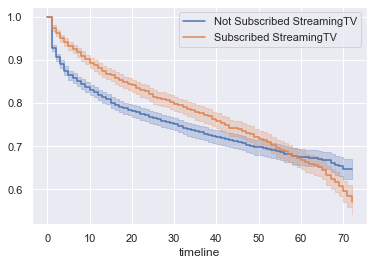

In [373]:
from lifelines import KaplanMeierFitter

T = ohe.tenure
E = ohe.Churn_Yes
kmf = KaplanMeierFitter()
#kmf.fit(T,E)
groups = ohe.StreamingTV
ix = (groups == 1)
kmf.fit(T[~ix],E[~ix],label='Not Subscribed StreamingTV') 
ax = kmf.plot_survival_function()
kmf.fit(T[ix],E[ix],label='Subscribed StreamingTV')
ax = kmf.plot_survival_function(ax=ax)

In [ ]:
# 5.2 Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12659.69
         time fit was run = 2021-02-07 01:00:57 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.03       1.04       0.06            -0.08             0.15                 0.93                 1.16
MultipleLines                           0.09       1.09       0.13            -0.16             0.33                 0.85                 1.40
OnlineSecurity                         -0.21       0.81       0.13            -0.47             0.05                 0.62                 1.05
OnlineBackup                           -0.06       0.95       0.13            -0.31             0.19                 0.74                 1.21
DeviceProtection                        0.09       1.09       0.13            -0.16             0.34                 0.85                 1.40
TechSupport                            -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.19
StreamingTV                             0.28       1.32       0.24            -0.18             0.74                 0.83                 2.10
StreamingMovies                         0.29       1.33       0.24            -0.18             0.75                 0.84                 2.11
MonthlyCharges                          0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gender_Male                            -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.05
Partner_Yes                            -0.18       0.84       0.06            -0.29            -0.07                 0.75                 0.93
Dependents_Yes                         -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
PhoneService_Yes                        0.83       2.29       0.47            -0.10             1.76                 0.90                 5.80
InternetService_Fiber optic             1.02       2.77       0.58            -0.12             2.15                 0.89                 8.59
InternetService_No                     -2.34       0.10       0.60            -3.51            -1.17                 0.03                 0.31
Contract_One year                      -1.27       0.28       0.10            -1.46            -1.07                 0.23                 0.34
Contract_Two year                      -3.70       0.02       0.20            -4.10            -3.31                 0.02                 0.04
PaperlessBilling_Yes                    0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.17                 0.83                 1.18
PaymentMethod_Electronic check          0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
PaymentMethod_Mailed check              0.51       1.67       0.09             0.34             0.68                 1.40                 1.98

                                           z      p   -log2(p)
covariate                                                     
SeniorCitizen                           0.61   0.54       0.88
MultipleL

None


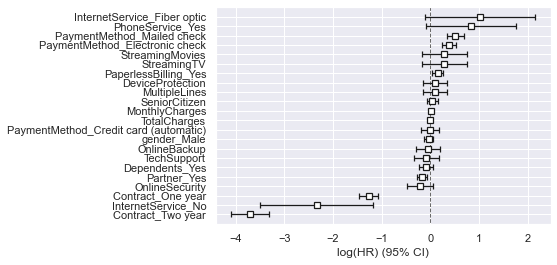

In [359]:
# CoxPHFitter regression:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(ohe, 'tenure', event_col='Churn_Yes')
print(cph.print_summary())
cph.plot()

<lifelines.WeibullAFTFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn_Yes'
   number of observations = 7043
number of events observed = 1869
           log-likelihood = -8145.38
         time fit was run = 2021-02-07 01:02:27 UTC

---
                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                     
lambda_ Contract_One year                       0.47       1.61       0.06             0.36             0.59                 1.43                 1.80
        Contract_Two year                       1.09       2.97       0.11             0.88             1.30                 2.41                 3.66
        Dependents_Yes                          0.09       1.10       0.04             0.01             0.18                 1.01                 1.19
        DeviceProtection                       -0.01       0.99       0.08            -0.16             0.15                 0.85                 1.16
        InternetService_Fiber optic            -0.57       0.57       0.36            -1.27             0.14                 0.28                 1.15
        InternetService_No                      1.00       2.73       0.37             0.29             1.72                 1.33                 5.60
        MonthlyCharges                         -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
        MultipleLines                          -0.00       1.00       0.08            -0.16             0.15                 0.86                 1.16
        OnlineBackup                            0.04       1.04       0.08            -0.12             0.19                 0.89                 1.21
        OnlineSecurity                          0.18       1.19       0.08             0.02             0.34                 1.02                 1.40
        PaperlessBilling_Yes                   -0.10       0.91       0.04            -0.17            -0.03                 0.84                 0.97
        Partner_Yes                             0.10       1.11       0.03             0.03             0.17                 1.04                 1.18
        PaymentMethod_Credit card (automatic)   0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
        PaymentMethod_Electronic check         -0.23       0.80       0.04            -0.32            -0.14                 0.73                 0.87
        PaymentMethod_Mailed check             -0.24       0.79       0.05            -0.35            -0.13                 0.71                 0.87
        PhoneService_Yes                       -0.19       0.83       0.29            -0.77             0.38                 0.47                 1.47
        SeniorCitizen                          -0.02       0.98       0.04            -0.09             0.05                 0.91                 1.05
        StreamingMovies                        -0.12       0.88       0.15            -0.41             0.16                 0.66                 1.18
        StreamingTV                            -0.14       0.87       0.15            -0.42             0.15                 0.65                 1.16
        TechSupport                             0.13       1.13       0.08            -0.04             0.29                 0.96                 1.33
        TotalCharges                            0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        gender_Male                             0.02       1.02       0.03            -0.04             0.08                 0.96                 1.08
        Intercept                      

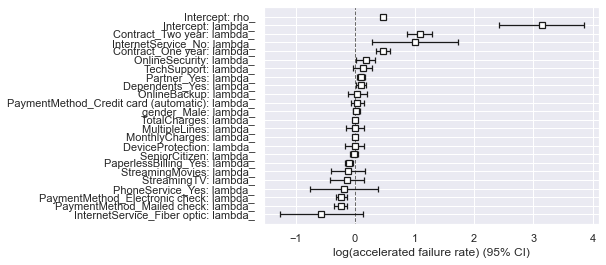

In [361]:
# WeibullAFTFitter Regression
from lifelines import WeibullAFTFitter

# Doesnt like '0's for tenure, sigh 
ohe.tenure = ohe.tenure +0.5

wft = WeibullAFTFitter()
wft.fit(ohe, 'tenure', event_col='Churn_Yes')
wft.print_summary()

wft.plot()

In [362]:
wft.summary

coef  exp(coef)  se(coef)  \
param   covariate                                                              
lambda_ Contract_One year                      0.474284   1.606864  0.058212   
        Contract_Two year                      1.087862   2.967923  0.107198   
        Dependents_Yes                         0.092563   1.096982  0.043261   
        DeviceProtection                      -0.007114   0.992911  0.078328   
        InternetService_Fiber optic           -0.565974   0.567807  0.359012   
        InternetService_No                     1.004130   2.729532  0.366744   
        MonthlyCharges                        -0.003806   0.996201  0.014266   
        MultipleLines                         -0.002414   0.997589  0.078008   
        OnlineBackup                           0.038528   1.039279  0.078792   
        OnlineSecurity                         0.177853   1.194650  0.082307   
        PaperlessBilling_Yes                  -0.098816   0.905910  0.035657   
        Partner_Yes                            0.100847   1.106108  0.033720   
        PaymentMethod_Credit card (automatic)  0.038219   1.038959  0.056683   
        PaymentMethod_Electronic check        -0.228859   0.795440  0.044886   
        PaymentMethod_Mailed check            -0.240694   0.786082  0.054068   
        PhoneService_Yes                      -0.191387   0.825813  0.292705   
        SeniorCitizen                         -0.021576   0.978655  0.035360   
        StreamingMovies                       -0.122763   0.884473  0.146133   
        StreamingTV                           -0.136308   0.872574  0.146500   
        TechSupport                            0.125740   1.133988  0.082386   
        TotalCharges                           0.000684   1.000684  0.000016   
        gender_Male                            0.020632   1.020846  0.029011   
        Intercept                              3.135601  23.002449  0.363781   
rho_    Intercept                              0.470758   1.601207  0.019774   

                                               coef lower 95%  coef upper 95%  \
param   covariate                                                               
lambda_ Contract_One year                            0.360192        0.588377   
        Contract_Two year                            0.877759        1.297966   
        Dependents_Yes                               0.007773        0.177352   
        DeviceProtection                            -0.160635        0.146407   
        InternetService_Fiber optic                 -1.269625        0.137678   
        InternetService_No                           0.285326        1.722935   
        MonthlyCharges                              -0.031766        0.024154   
        MultipleLines                               -0.155307        0.150479   
        OnlineBackup                                -0.115902        0.192957   
        OnlineSecurity                               0.016535        0.339172   
        PaperlessBilling_Yes                        -0.168701       -0.028930   
        Partner_Yes                                  0.034758        0.166937   
        PaymentMethod_Credit card (automatic)       -0.072877        0.149316   
        PaymentMethod_Electronic check              -0.316834       -0.140885   
        PaymentMethod_Mailed check                  -0.346665       -0.134723   
        PhoneService_Yes                            -0.765079        0.382306   
        SeniorCitizen                               -0.090879        0.047727   
        StreamingMovies                             -0.409178        0.163651   
        StreamingTV                                 -0.423443        0.150826   
        TechSupport                                 -0.035733        0.287214   
        TotalCharges                                 0.000653        0.000714   
        gender_Male                                 -0.036229        0.077492   
        Intercept         

In [ ]:
# import statsmodels.api as sm

# y = ohe.tenure
# X = ohe.drop(columns='tenure')


# est = sm.PHReg(y, X).fit()
# est.summary()

In [ ]:
# telco.TotalCharges = pd.to_numeric(telco.TotalCharges, errors='coerce')

# telco.TotalCharges[telco.TotalCharges.isnull()] = telco.MonthlyCharges

# telco.TotalCharges[telco.TotalCharges.isnull()]

# telco['StreamingTV_yn'] = telco['StreamingTV'].eq('Yes').mul(1)

# telco['Churn'] = telco['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# telco['StreamingTV_yn'] = telco['StreamingTV'].apply(lambda x: 0 if x == 'No' else 1 )

# telco['StreamingTV'] = telco['StreamingTV'].apply(lambda x: "No" if x == "No internet service" else x)

In [ ]:
# DUMMY VARIABLES TEND TO BE SUSCEPTIBLE TO SADDLE POINTS - IMPORTANT TO REMEMBER 